In [1]:
from influxdb import DataFrameClient
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open('influxdb.json') as f:
    db_info = json.load(f)
influx_client = DataFrameClient(**db_info, database='ChameleonSimulator')

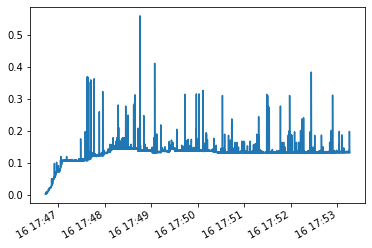

In [3]:
query_str = 'SELECT * FROM resource_pool'
df = influx_client.query(query_str)['resource_pool']
df.to_csv('data/rp-1.csv')
# df = pd.read_csv('data/rp-2.csv').iloc[:5000]
utl = 1-(df['ch-free']/(df['chi-inuse']+df['osg-inuse']+df['ch-free']))
utl.plot()
plt.show()

In [4]:
utl.mean(), utl.median(), utl.std()

(0.12977779859294647, 0.13186813186813184, 0.02995632463871914)

In [5]:
# lstm terminated jobs 16
# no-lstm terminated jobs 9

In [6]:
stop = df.iloc[-1].to_frame().T.index

In [7]:
query_str = 'SELECT * FROM osg_jobs'
osg = influx_client.query(query_str)['osg_jobs']
osg.reset_index(inplace=True)

In [8]:
times = [x for x in pd.to_datetime(osg['index']).to_list() if x < stop]
osg[osg['index'].isin(times)]

,index,completed,pending,running,terminated
0,2021-07-16 17:46:45.394954+00:00,0,260,1,0
1,2021-07-16 17:46:45.449688+00:00,1,277,1,0
2,2021-07-16 17:46:45.511060+00:00,2,304,1,0
3,2021-07-16 17:46:45.515708+00:00,2,318,1,0
4,2021-07-16 17:46:45.621223+00:00,3,372,1,0
...,...,...,...,...,...
31799,2021-07-16 17:51:50.970933+00:00,5158,0,1,7
31800,2021-07-16 17:51:51.010140+00:00,5158,0,1,7
31801,2021-07-16 17:51:51.044350+00:00,5158,0,1,7
31802,2021-07-16 17:51:51.088840+00:00,5158,0,1,7
